# **Clasificación KNN y Random Forest Proyecto**

#### Integrantes
- *Santiago Cassiano Rozo*
- *Fabian Camilo Castro Lozano*
- *David Jose Leon Aroca*

#Acceso a librerias, a los datasets desde google drive

Acceso a los datasets en google drive

In [71]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importamos las librerias que utilizaremos a lo largo de la clasificación

In [72]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#0. Lectura y preparación de los datos para los algoritmos de clasificación.

Leemos el dataset completamente numerico que generamos en la fase de preprocesamiento. Pero removemos el atributo duration, ya que queremos hacer un modelo que prediga si el cliente acepta o no el deposito previo a la llamada.

In [73]:
df_num_original = pd.read_csv("/content/gdrive/Shareddrives/Minería de datos/Proyecto/I. Dataset/numerico.csv", sep=",")
#Eliminamos la columna de los indices (Unnamed 0)
df_num_original.drop(columns=['Unnamed: 0','duration'], inplace=True)

df_num_original

,age,education,default,balance,housing,loan,contact,day,month,campaign,...,services,student,technician,unemployed,divorced,married,single,failure,other,success
0,58,3,0,2143,1,0,0,5,5,1,...,0,0,0,0,0,1,0,1,0,0
1,44,2,0,29,1,0,0,5,5,1,...,0,0,1,0,0,0,1,1,0,0
2,33,2,0,2,1,1,0,5,5,1,...,0,0,0,0,0,1,0,1,0,0
3,47,2,0,1506,1,0,0,5,5,1,...,0,0,0,0,0,1,0,1,0,0
4,33,2,0,1,0,0,0,5,5,1,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,23,3,0,113,0,0,0,17,11,1,...,0,1,0,0,0,0,1,1,0,0
41086,25,2,0,505,0,1,0,17,11,2,...,0,0,1,0,0,0,1,1,0,0
41087,51,3,0,825,0,0,0,17,11,3,...,0,0,1,0,0,1,0,1,0,0
41088,71,1,0,1729,0,0,0,17,11,2,...,0,0,0,0,1,0,0,1,0,0


Creamos dos datasets. Uno con las clases de todos los elementos y otro con todos los datos menos la clase.

In [74]:
#Dataframe solo con los datos de los atributos numericos
df_num_original_data = df_num_original.drop(columns='y')
#Dataframe con las clases de cada registro. 1 significa "yes", 0 significa "no"
df_num_original_classes = df_num_original['y']

print(df_num_original_data)
print(df_num_original_classes)

       age  education  default  balance  housing  loan  contact  day  month  \
0       58          3        0     2143        1     0        0    5      5   
1       44          2        0       29        1     0        0    5      5   
2       33          2        0        2        1     1        0    5      5   
3       47          2        0     1506        1     0        0    5      5   
4       33          2        0        1        0     0        0    5      5   
...    ...        ...      ...      ...      ...   ...      ...  ...    ...   
41085   23          3        0      113        0     0        0   17     11   
41086   25          2        0      505        0     1        0   17     11   
41087   51          3        0      825        0     0        0   17     11   
41088   71          1        0     1729        0     0        0   17     11   
41089   57          2        0      668        0     0        1   17     11   

       campaign  ...  services  student  technician

Estandarizamos los datos de cada columna para que tengan media=0 y desviación estandar=1, esto para prevenir que los atributos con rangos de valores más grandes tengan más peso en la clasificación.

In [75]:
#Creamos el objeto escalador
scaler = StandardScaler()
#Ajustamos el escalador a los datos
scaler.fit(df_num_original_data)
#Escalamos los datos y creamos un nuevo dataframe con los datos standarizados
df_num_standard_data = pd.DataFrame(data=scaler.transform(df_num_original_data), columns=df_num_original_data.columns)
df_num_standard_data

,age,education,default,balance,housing,loan,contact,day,month,campaign,...,services,student,technician,unemployed,divorced,married,single,failure,other,success
0,1.716911,1.326505,-0.138101,0.613195,0.888307,-0.443316,-0.249447,-1.294860,-0.470331,-0.740412,...,-0.322638,-0.143318,-0.451074,-0.173146,-0.360763,0.811290,-0.626351,0.246461,-0.174853,-0.168467
1,0.332788,-0.212911,-0.138101,-0.603598,0.888307,-0.443316,-0.249447,-1.294860,-0.470331,-0.740412,...,-0.322638,-0.143318,2.216931,-0.173146,-0.360763,-1.232604,1.596550,0.246461,-0.174853,-0.168467
2,-0.754738,-0.212911,-0.138101,-0.619139,0.888307,2.255728,-0.249447,-1.294860,-0.470331,-0.740412,...,-0.322638,-0.143318,-0.451074,-0.173146,-0.360763,0.811290,-0.626351,0.246461,-0.174853,-0.168467
3,0.629385,-0.212911,-0.138101,0.246545,0.888307,-0.443316,-0.249447,-1.294860,-0.470331,-0.740412,...,-0.322638,-0.143318,-0.451074,-0.173146,-0.360763,0.811290,-0.626351,0.246461,-0.174853,-0.168467
4,-0.754738,-0.212911,-0.138101,-0.619715,-1.125737,-0.443316,-0.249447,-1.294860,-0.470331,-0.740412,...,-0.322638,-0.143318,-0.451074,-0.173146,-0.360763,-1.232604,1.596550,0.246461,-0.174853,-0.168467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,-1.743397,1.326505,-0.138101,-0.555249,-1.125737,-0.443316,-0.249447,0.149867,2.039528,-0.740412,...,-0.322638,6.977507,-0.451074,-0.173146,-0.360763,-1.232604,1.596550,0.246461,-0.174853,-0.168467
41086,-1.545665,-0.212911,-0.138101,-0.329618,-1.125737,2.255728,-0.249447,0.149867,2.039528,-0.234769,...,-0.322638,-0.143318,2.216931,-0.173146,-0.360763,-1.232604,1.596550,0.246461,-0.174853,-0.168467
41087,1.024849,1.326505,-0.138101,-0.145430,-1.125737,-0.443316,-0.249447,0.149867,2.039528,0.270874,...,-0.322638,-0.143318,2.216931,-0.173146,-0.360763,0.811290,-0.626351,0.246461,-0.174853,-0.168467
41088,3.002168,-1.752327,-0.138101,0.374901,-1.125737,-0.443316,-0.249447,0.149867,2.039528,-0.234769,...,-0.322638,-0.143318,-0.451074,-0.173146,2.771900,-1.232604,-0.626351,0.246461,-0.174853,-0.168467


Se hace un muestreo estratificado para obtener un conjunto de datos de entrenamiento con un total del 70% de los datos y otro conjunto de datos de prueba con un total del 30% de los datos.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_num_standard_data.values, df_num_original_classes.values,
                                                    test_size=0.3,
                                                    random_state=0)

#1. Clasificación con el algoritmo K-NearestNeighbors sobre todo el dataset con distancia Euclideana.

A continuación vamos a ejecutar el algoritmo de K-NearestNeighbors con diferentes valores de K evaluando el error que tienen cada uno para ver cual es el valor optimo de K para el algoritmo KNearestNeighbors.

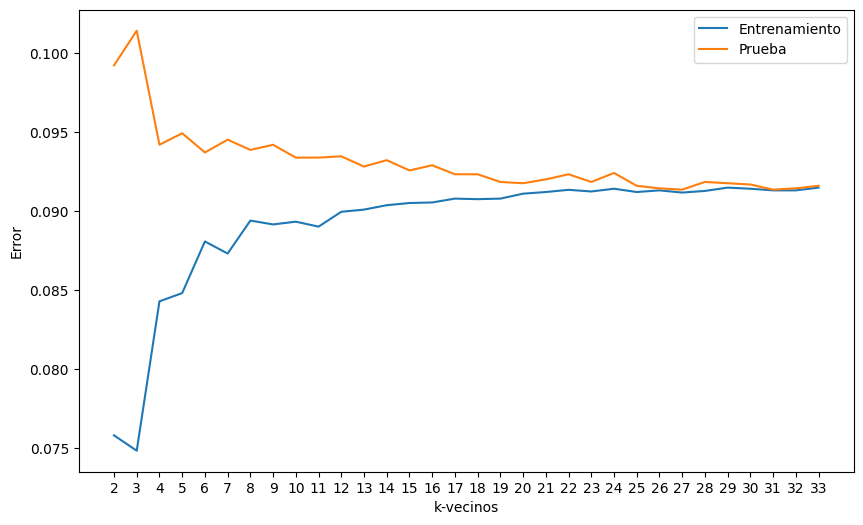

In [77]:
#Se evaluara el error con K de 2 a 33
k_values = list(range(2,34))

#Listas para ir almacenando el error de entrenamiento y generalización
train_error = []
test_error = []

#Bucle de ejecución de todas las posibilidades de K
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_error.append(1 - knn.score(X_train, y_train))
    test_error.append(1 - knn.score(X_test, y_test))

#Lineas para visualizar la curva de aprendizaje
pl.figure(figsize = (10, 6))
pl.plot(k_values, train_error, label="Entrenamiento")
pl.plot(k_values, test_error, label="Prueba")
pl.xticks(k_values)
pl.xlabel("k-vecinos")
pl.ylabel("Error")
plt.legend()

A partir de la curva de aprendizaje se observa que el mejor valor para K corresponde a 31 y vemos que el error tiende a concentrarse en un valor cercano a 9.25%

A continuación crearemos un modelo de clasificación con K=31 y evaluaremos su rendimiento con diferentes metricas.

Matriz de confusión 31-NearestNeighbors sobre un dataset desbalanceado:
--------------------------------------------------


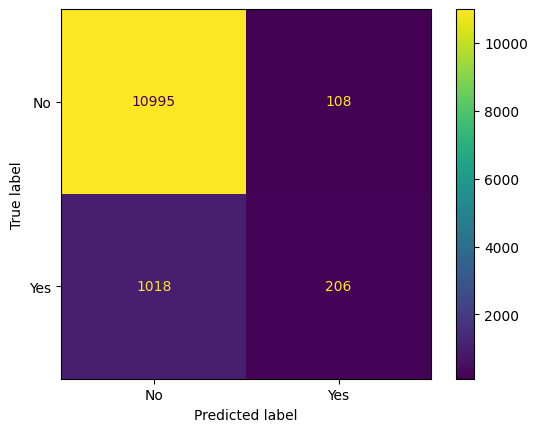


Medidas de validación 19-NearestNeighbors
--------------------------------------------------
Accuracy = 0.9086557962196804
Precision = 0.6560509554140127
Recall = 0.16830065359477125
F1 score = 0.2678803641092328


In [78]:
#Creación del modelo
knn_31 = KNeighborsClassifier(n_neighbors=31)
knn_31.fit(X_train, y_train)

#Se realizan las prediciones sobre le conjunto de datos de prueba
y_pred_knn_31 = knn_31.predict(X_test)

#Se calcula la matriz de confusión sobre los resultados del modelo y a partir de ello calculamos varias matricas
conf_mat_knn_31 = confusion_matrix(y_test, y_pred_knn_31)

accuracy_knn_31 = (conf_mat_knn_31[0,0] + conf_mat_knn_31[1,1])/len(y_pred_knn_31)
precision_knn_31 = (conf_mat_knn_31[1,1]) / (conf_mat_knn_31[1,1] + conf_mat_knn_31[0,1])
recall_knn_31 = (conf_mat_knn_31[1,1]) / (conf_mat_knn_31[1,1] + conf_mat_knn_31[1,0])
f1_score_knn_31 = (2*precision_knn_31*recall_knn_31)/(precision_knn_31+recall_knn_31)

#Imprimimos la matriz de confusion y los resultados de las medidas:
print("Matriz de confusión 31-NearestNeighbors sobre un dataset desbalanceado:")
print("--------------------------------------------------")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_knn_31, display_labels=["No","Yes"])
disp.plot()
plt.show()
print()

print("Medidas de validación 19-NearestNeighbors")
print("--------------------------------------------------")
print(f"Accuracy = {accuracy_knn_31}")
print(f"Precision = {precision_knn_31}")
print(f"Recall = {recall_knn_31}")
print(f"F1 score = {f1_score_knn_31}")

Se observa que a pesar de que el clasificador obtiene un valor muy alto de accuracy (91%), en realidad este valor lo obtiene porque clasifica todos los individuos en la clase negativa, la cual es la clase mayoritaria del conjunto de datos. Por otra parte, en las otras medidas se observa que el clasificador tiene un rendimiento muy pobre para encontrar los individuos que realmente pertenecen a la clase positiva.


Este es un resultado que era esperado, debido a que el dataset es desbalanceado (Aproximadamente el 90% de las personas no aceptaron el deposito a plazo y el 10% si lo aceptaron). Debido a que hay muchas más personas de la clase negativa, usualmente se encontrarán muchos más vecinos de esa clase y tendera a clasificar todos los individuos como "no".

Finalmente, por curiosidad probamos ejecutar el modelo obtenido sobre todo el conjunto de datos de manera que podamos observar su rendimiento.

Matriz de confusión 31-NearestNeighbors entrenado con desbalance sobre todos los datos del conjunto:
--------------------------------------------------


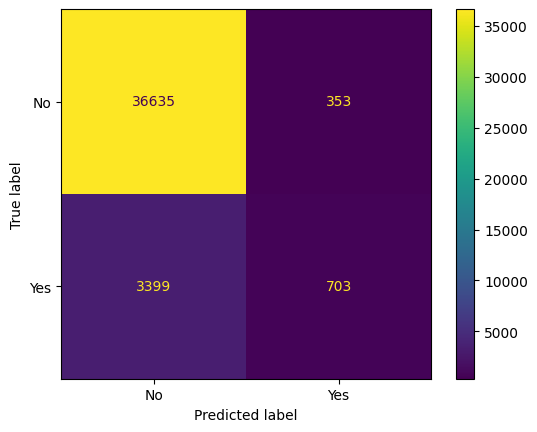


Medidas de validación 31-NearestNeighbors entrenado con desbalance sobre todos los datos del conjunto
--------------------------------------------------
Accuracy = 0.9086882453151618
Precision = 0.665719696969697
Recall = 0.17137981472452463
F1 score = 0.2725862737495153


In [79]:
#Se realizan las prediciones sobre le conjunto de datos de prueba
y_pred_knn_31 = knn_31.predict(df_num_standard_data.values)

#Se calcula la matriz de confusión sobre los resultados del modelo y a partir de ello calculamos varias matricas
conf_mat_knn_31 = confusion_matrix(df_num_original_classes.values, y_pred_knn_31)

accuracy_knn_31 = (conf_mat_knn_31[0,0] + conf_mat_knn_31[1,1])/len(y_pred_knn_31)
precision_knn_31 = (conf_mat_knn_31[1,1]) / (conf_mat_knn_31[1,1] + conf_mat_knn_31[0,1])
recall_knn_31 = (conf_mat_knn_31[1,1]) / (conf_mat_knn_31[1,1] + conf_mat_knn_31[1,0])
f1_score_knn_31 = (2*precision_knn_31*recall_knn_31)/(precision_knn_31+recall_knn_31)

#Imprimimos la matriz de confusion y los resultados de las medidas:
print("Matriz de confusión 31-NearestNeighbors entrenado con desbalance sobre todos los datos del conjunto:")
print("--------------------------------------------------")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_knn_31, display_labels=["No","Yes"])
disp.plot()
plt.show()
print()

print("Medidas de validación 31-NearestNeighbors entrenado con desbalance sobre todos los datos del conjunto")
print("--------------------------------------------------")
print(f"Accuracy = {accuracy_knn_31}")
print(f"Precision = {precision_knn_31}")
print(f"Recall = {recall_knn_31}")
print(f"F1 score = {f1_score_knn_31}")

Sobre todo el conjunto de datos se ve que tiene un rendimiento bajo, puesto que no logra identificar los individuos de la clase positiva y tiende a clasificar a todos los individuos en la clase negativa.

#2. Clasificación con Random Forest sobre todo el conjunto de datos

A continuación se va a ejecutar una busqueda para identificar los mejores parametros para este tipo de clasificador. Los parametros que se van a modificar son "n_estimators" el cual indica cuantos arboles construir para hacer el random forest y max_features, el cual indica el procentaje de atributos que se va a utilizar para constuir los arboles de decisión.

In [80]:
param_grid = {'n_estimators':[5, 15, 25, 35, 45, 55], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=2, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9, 1.0],
                         'n_estimators': [5, 15, 25, 35, 45, 55]},
             verbose=2)

A partir del proceso anterior obtenemos el valor de los mejores parametros para el random forest y el accuracy que se obtuvo con dichos parametros.

In [81]:
print("Mejores parametros: ",clf.best_params_)
print("Accuracy promedio obtenido con dicha configuracion: ",clf.best_score_)

Mejores parametros:  {'max_features': 0.1, 'n_estimators': 55}
Accuracy promedio obtenido con dicha configuracion:  0.9072766956926628


A continuacion creamos un clasificador random forest con los parametros indicados anteriormente y calculamos algunas medidas para evaluar su rendimiento.

Matriz de confusión Random Forest entrenado con desbalance:
--------------------------------------------------


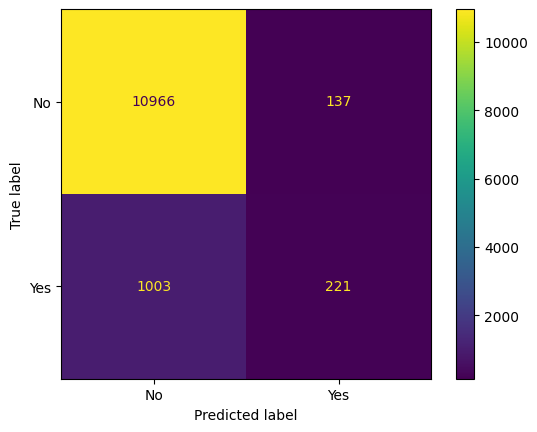


Medidas de validación Random Forest entrenado con desbalance
--------------------------------------------------
Accuracy = 0.9075200778778292
Precision = 0.61731843575419
Recall = 0.18055555555555555
F1 score = 0.27939317319848295


In [82]:
#Creación del modelo
rf = RandomForestClassifier(n_estimators=55, max_features=0.1)
rf.fit(X_train, y_train);

#Se realizan las prediciones sobre le conjunto de datos de prueba
y_pred_rf = rf.predict(X_test)

#Se calcula la matriz de confusión sobre los resultados del modelo y a partir de ello calculamos varias matricas
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)

accuracy_rf = (conf_mat_rf[0,0] + conf_mat_rf[1,1])/len(y_pred_rf)
precision_rf = (conf_mat_rf[1,1]) / (conf_mat_rf[1,1] + conf_mat_rf[0,1])
recall_rf = (conf_mat_rf[1,1]) / (conf_mat_rf[1,1] + conf_mat_rf[1,0])
f1_score_rf = (2*precision_rf*recall_rf)/(precision_rf+recall_rf)

#Imprimimos la matriz de confusion y los resultados de las medidas:
print("Matriz de confusión Random Forest entrenado con desbalance:")
print("--------------------------------------------------")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_rf, display_labels=["No","Yes"])
disp.plot()
plt.show()
print()

print("Medidas de validación Random Forest entrenado con desbalance")
print("--------------------------------------------------")
print(f"Accuracy = {accuracy_rf}")
print(f"Precision = {precision_rf}")
print(f"Recall = {recall_rf}")
print(f"F1 score = {f1_score_rf}")

Otro aspecto interesante del modelo random forest es que nos permite ver cuales fueron los atributos más importantes a la hora de construir los arboles de decisión. En la siguiente celda se observa que los atributos más importantes son la columna 1, 4 y 8. Las cuales corresponden a Age, Balance y Month.

In [83]:
print(rf.feature_importances_)

[0.17314544 0.02639194 0.00272715 0.19928196 0.02719487 0.01182041
 0.00886348 0.15363614 0.11001457 0.05954516 0.04964343 0.02821846
 0.00718181 0.00681203 0.00327483 0.00313378 0.00736628 0.00463587
 0.00392384 0.00542695 0.00456907 0.00805358 0.00456173 0.00547374
 0.00803467 0.00751448 0.02046245 0.00475214 0.04433975]


Finalmente se observa que Random Forest tambien cae en el mismo problema que KNearestNeighbors, debido a que intenta clasificar casi todo en la clase mayoritaria, pero tiene grandes problemas a la hora de clasificar los elementos de la clase positiva, por lo cual obtiene un F1 score bajo.

Finalmente, por curiosidad, se va a probar el rendimiento de este algoritmo sobre todo el conjunto de datos, para ver si logra predecir correctamente la clase de todos los elementos del conjunto.

Matriz de confusión Random Forest entrenado con desbalance sobre todo el conjunto de datos:
--------------------------------------------------


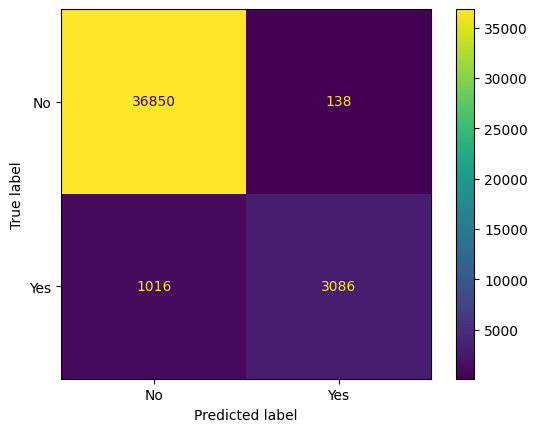


Medidas de validación Random Forest entrenado con desbalance sobre todo el conjunto de datos
--------------------------------------------------
Accuracy = 0.9719153078607934
Precision = 0.957196029776675
Recall = 0.7523159434422233
F1 score = 0.8424788424788424


In [84]:
#Se realizan las prediciones sobre todo el conjunto de datos
y_pred_rf = rf.predict(df_num_standard_data.values)

#Se calcula la matriz de confusión sobre los resultados del modelo y a partir de ello calculamos varias matricas
conf_mat_rf = confusion_matrix(df_num_original_classes.values, y_pred_rf)

accuracy_rf = (conf_mat_rf[0,0] + conf_mat_rf[1,1])/len(y_pred_rf)
precision_rf = (conf_mat_rf[1,1]) / (conf_mat_rf[1,1] + conf_mat_rf[0,1])
recall_rf = (conf_mat_rf[1,1]) / (conf_mat_rf[1,1] + conf_mat_rf[1,0])
f1_score_rf = (2*precision_rf*recall_rf)/(precision_rf+recall_rf)

#Imprimimos la matriz de confusion y los resultados de las medidas:
print("Matriz de confusión Random Forest entrenado con desbalance sobre todo el conjunto de datos:")
print("--------------------------------------------------")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_rf, display_labels=["No","Yes"])
disp.plot()
plt.show()
print()

print("Medidas de validación Random Forest entrenado con desbalance sobre todo el conjunto de datos")
print("--------------------------------------------------")
print(f"Accuracy = {accuracy_rf}")
print(f"Precision = {precision_rf}")
print(f"Recall = {recall_rf}")
print(f"F1 score = {f1_score_rf}")

El resultado es bastante sorprendente, pueso que logra clasificar muy bien en general ambas clases al aplicar el modelo sobre todo el conjunto de datos. En cambio cuando lo hizo con sus datos de prueba tuvo un resultado no tan favorable. Esto puede deberse a que aprendio muy bien los datos de entrenamiento, los cuales corresponden al 70% de los datos del conjunto de esta ultima prueba.

#Algoritmos KNearestNeighbors con un dataset balanceado

Vamos a generar un dataset balanceado con 4102 personas de la clase yes y 4102 personas de la clase no. Esto para ver si se obtiene un mejor rendimiento en los algoritmos.

In [85]:
#Obtenemos las filas de personas que dijeron que no y personas que dijeron que si
df_num_original_no = df_num_original[df_num_original['y'] == 0].reset_index()
df_num_original_yes = df_num_original[df_num_original['y'] == 1].reset_index()

#En total hay 4102 personas que son de la clase "yes"
#Crearemos un dataset con las primeras con las 4102 personas que dijeron que no y las 4102 personas que dijeron que si
df_num_balanced = pd.concat([df_num_original_yes, df_num_original_no.sample(n=4102)]).reset_index().drop(columns=["level_0","index"])

#Imprimimos el dataset balanceado y la cantidad de elementos de cada clase
print(df_num_balanced)
print("Cantidad de elementos por clase: ")
print(df_num_balanced['y'].value_counts())

      age  education  default  balance  housing  loan  contact  day  month  \
0      59          2        0     2343        1     0        0    5      5   
1      55          2        0     2476        1     0        0    5      5   
2      54          3        0      184        0     0        0    5      5   
3      42          3        0        0        1     1        0    5      5   
4      37          2        0        1        1     0        0    6      5   
...   ...        ...      ...      ...      ...   ...      ...  ...    ...   
8199   49          1        0      355        1     0        0    2      6   
8200   32          3        0      933        1     0        0   12      5   
8201   28          3        0        1        0     0        0   15      7   
8202   53          2        0     1139        1     0        0   16      5   
8203   28          2        0     1154        0     0        0   29      7   

      campaign  ...  services  student  technician  unemployed 

Creamos dos dataframe, uno con unicamente los datos y otro con las clases. Posteriormente estandarizamos los datos.

In [87]:
#Dataframe solo con los atributos numericos
df_num_balanced_data = df_num_balanced.drop(columns='y')

#Dataframe con la columna que indica la clase de cada registro. 1 significa "yes", 0 significa "no"
df_num_balanced_classes = df_num_balanced['y']

#Creamos el objeto escalador
scaler = StandardScaler()
#Ajustamos el escalador a los datos
scaler.fit(df_num_original_data)
#Escalamos los datos y creamos un nuevo dataframe con los datos standarizados
df_num_bal_standard_data = pd.DataFrame(data=scaler.transform(df_num_balanced_data), columns=df_num_balanced_data.columns)

print(df_num_bal_standard_data)
print(df_num_balanced_classes)

           age  education   default   balance   housing      loan   contact  \
0     1.815777  -0.212911 -0.138101  0.728313  0.888307 -0.443316 -0.249447   
1     1.420313  -0.212911 -0.138101  0.804866  0.888307 -0.443316 -0.249447   
2     1.321447   1.326505 -0.138101 -0.514382 -1.125737 -0.443316 -0.249447   
3     0.135056   1.326505 -0.138101 -0.620291  0.888307  2.255728 -0.249447   
4    -0.359274  -0.212911 -0.138101 -0.619715  0.888307 -0.443316 -0.249447   
...        ...        ...       ...       ...       ...       ...       ...   
8199  0.827117  -1.752327 -0.138101 -0.415957  0.888307 -0.443316 -0.249447   
8200 -0.853604   1.326505 -0.138101 -0.083267  0.888307 -0.443316 -0.249447   
8201 -1.249067   1.326505 -0.138101 -0.619715 -1.125737 -0.443316 -0.249447   
8202  1.222581  -0.212911 -0.138101  0.035304  0.888307 -0.443316 -0.249447   
8203 -1.249067  -0.212911 -0.138101  0.043938 -1.125737 -0.443316 -0.249447   

           day     month  campaign  ...  services  

Se hace un muestreo estratificado para obtener un conjunto de datos de entrenamiento con un total del 70% de los datos y otro conjunto de datos de prueba con un total del 30% de los datos.

In [88]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(df_num_bal_standard_data.values, df_num_balanced_classes.values,test_size=0.3,random_state=0)

A continuación vamos a ejecutar el algoritmo de K-NearestNeighbors con diferentes valores de K evaluando el error que tienen cada uno para ver cual es el valor optimo de K para el algoritmo KNearestNeighbors para el dataset balanceado.


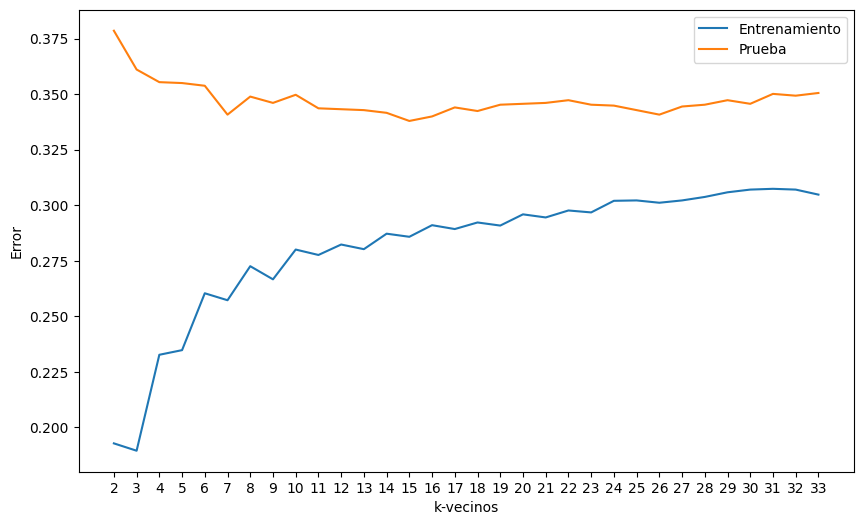

In [89]:
#Se evaluara el error con K de 2 a 33
k_values = list(range(2,34))

#Listas para ir almacenando el error de entrenamiento y generalización
train_error = []
test_error = []

#Bucle de ejecución de todas las posibilidades de K
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_bal, y_train_bal)
    train_error.append(1 - knn.score(X_train_bal, y_train_bal))
    test_error.append(1 - knn.score(X_test_bal, y_test_bal))

#Lineas para visualizar la curva de aprendizaje
pl.figure(figsize = (10, 6))
pl.plot(k_values, train_error, label="Entrenamiento")
pl.plot(k_values, test_error, label="Prueba")
pl.xticks(k_values)
pl.xlabel("k-vecinos")
pl.ylabel("Error")
plt.legend()

Segun la grafica, 15 vecinos es el valor de k que minimiza el error de validación, asi que ahora se construira un modelo con 15 vecinos y se medira su rendimiento con los datos de prueba del dataset.

Matriz de confusión 15-NearestNeighbors entrenado con dataset balanceado:
--------------------------------------------------


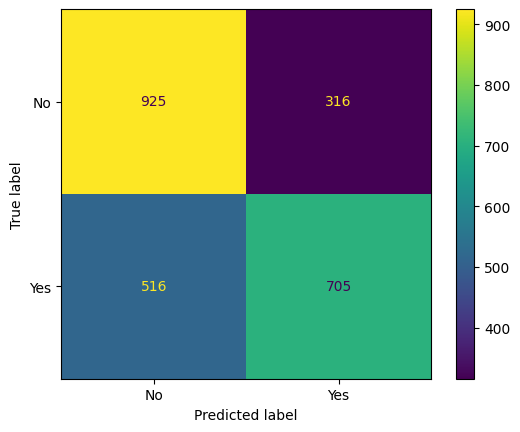


Medidas de validación 15-NearestNeighbors entrenado con dataset balanceado:
--------------------------------------------------
Accuracy = 0.6620633631194152
Precision = 0.6904995102840352
Recall = 0.5773955773955773
Especificidad = 0.7453666398066076
F1 score = 0.6289027653880463


In [100]:
#Creación del modelo
knn_15 = KNeighborsClassifier(n_neighbors=15)
knn_15.fit(X_train_bal, y_train_bal)

#Se realizan las prediciones sobre le conjunto de datos de prueba
y_pred_knn_15 = knn_15.predict(X_test_bal)

#Se calcula la matriz de confusión sobre los resultados del modelo y a partir de ello calculamos varias matricas
conf_mat_knn_15 = confusion_matrix(y_test_bal, y_pred_knn_15)

accuracy_knn_15 = (conf_mat_knn_15[0,0] + conf_mat_knn_15[1,1])/len(y_pred_knn_15)
precision_knn_15 = (conf_mat_knn_15[1,1]) / (conf_mat_knn_15[1,1] + conf_mat_knn_15[0,1])
recall_knn_15 = (conf_mat_knn_15[1,1]) / (conf_mat_knn_15[1,1] + conf_mat_knn_15[1,0])
especificidad_knn_15 = conf_mat_knn_15[0,0] / (conf_mat_knn_15[0,0] + conf_mat_knn_15[0,1])
f1_score_knn_15 = (2*precision_knn_15*recall_knn_15)/(precision_knn_15+recall_knn_15)

#Imprimimos la matriz de confusion y los resultados de las medidas:
print("Matriz de confusión 15-NearestNeighbors entrenado con dataset balanceado:")
print("--------------------------------------------------")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_knn_15, display_labels=["No","Yes"])
disp.plot()
plt.show()
print()

print("Medidas de validación 15-NearestNeighbors entrenado con dataset balanceado:")
print("--------------------------------------------------")
print(f"Accuracy = {accuracy_knn_15}")
print(f"Precision = {precision_knn_15}")
print(f"Recall = {recall_knn_15}")
print(f"Especificidad = {especificidad_knn_15}")
print(f"F1 score = {f1_score_knn_15}")

Se observa que el rendimiento del clasificador entrenado a partir del dataset balanceado y puesto a prueba con datos balanceados es mucho mejor que cuando se ejecutaba el algoritmo con todos los datos. Aunque tiene un menor accuracy, tiene un F1-score mucho mejor, esto debido a que si logra distinguir varios individuos de la clase "no" y de la clase "yes".

A continuación vamos a poner a prueba el clasificador creado con el dataset balanceado con los datos de todo el conjunto de datos, para observar su resultado.

Matriz de confusión 15-NearestNeighbors entrenado con dataset balanceado probando con todos los datos:
--------------------------------------------------


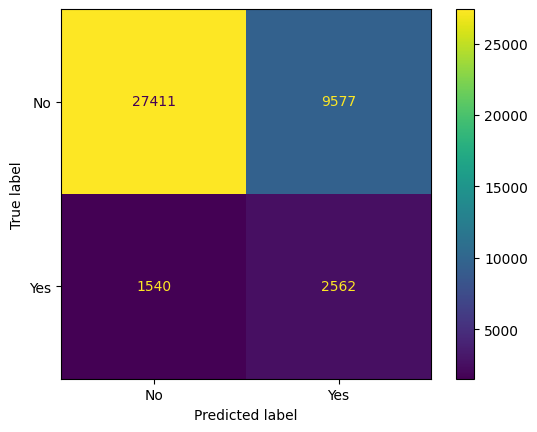


Medidas de validación 15-NearestNeighbors entrenado con dataset balanceado probando con todos los datos:
--------------------------------------------------
Accuracy = 0.7294475541494281
Precision = 0.21105527638190955
Recall = 0.6245733788395904
F1 score = 0.315497814174004


In [92]:
#Se realizan las prediciones sobre todo el conjunto de datos
y_pred_knn_15 = knn_15.predict(df_num_standard_data.values)

#Se calcula la matriz de confusión sobre los resultados del modelo y a partir de ello calculamos varias matricas
conf_mat_knn_15 = confusion_matrix(df_num_original_classes.values, y_pred_knn_15)

accuracy_knn_15 = (conf_mat_knn_15[0,0] + conf_mat_knn_15[1,1])/len(y_pred_knn_15)
precision_knn_15 = (conf_mat_knn_15[1,1]) / (conf_mat_knn_15[1,1] + conf_mat_knn_15[0,1])
recall_knn_15 = (conf_mat_knn_15[1,1]) / (conf_mat_knn_15[1,1] + conf_mat_knn_15[1,0])
f1_score_knn_15 = (2*precision_knn_15*recall_knn_15)/(precision_knn_15+recall_knn_15)

#Imprimimos la matriz de confusion y los resultados de las medidas:
print("Matriz de confusión 15-NearestNeighbors entrenado con dataset balanceado probando con todos los datos:")
print("--------------------------------------------------")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_knn_15, display_labels=["No","Yes"])
disp.plot()
plt.show()
print()

print("Medidas de validación 15-NearestNeighbors entrenado con dataset balanceado probando con todos los datos:")
print("--------------------------------------------------")
print(f"Accuracy = {accuracy_knn_15}")
print(f"Precision = {precision_knn_15}")
print(f"Recall = {recall_knn_15}")
print(f"F1 score = {f1_score_knn_15}")

Se observa que el clasificador aunque logra identificar varias de las personas que si aceptarian el deposito a plazo, tambien tiene una tasa importante de falsos positivos. Pero es interesante observar que no tiende a agrupar a todos los elementos en una misma clase.

#Pruebas con random forest y un dataset balanceado

A continuación se va a ejecutar una busqueda para identificar los mejores parametros para este tipo de clasificador. Esta vez se hara sobre el dataset balanceado construido previamente.

In [93]:
param_grid = {'n_estimators':[5, 15, 25, 35, 45, 55], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=2, n_jobs=-1, cv=5)
clf.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9, 1.0],
                         'n_estimators': [5, 15, 25, 35, 45, 55]},
             verbose=2)

A partir del proceso anterior obtenemos el valor de los mejores parametros para el random forest y el accuracy que se obtuvo con dichos parametros.

In [94]:
print("Mejores parametros: ",clf.best_params_)
print("Accuracy promedio obtenido con dicha configuracion: ",clf.best_score_)

Mejores parametros:  {'max_features': 0.4, 'n_estimators': 45}
Accuracy promedio obtenido con dicha configuracion:  0.7157769367697406


A continuacion creamos un clasificador random forest con los parametros indicados anteriormente y calculamos algunas medidas para evaluar su rendimiento.

Matriz de confusión Random Forest con un dataset balanceado:
--------------------------------------------------


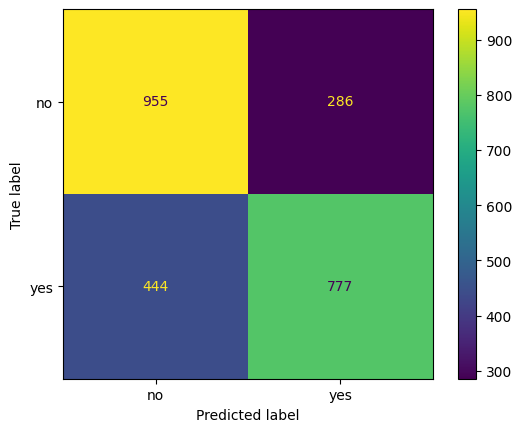


Medidas de validación Random Forest con un dataset balanceado
--------------------------------------------------
Accuracy = 0.7034930950446792
Precision = 0.7309501411100658
Recall = 0.6363636363636364
Especificidad = 0.7695406929895245
F1 score = 0.6803852889667251


In [98]:
#Creación del modelo
rf = RandomForestClassifier(n_estimators=45, max_features=0.4)
rf.fit(X_train_bal, y_train_bal);

#Se realizan las prediciones sobre le conjunto de datos de prueba
y_pred_rf = rf.predict(X_test_bal)

#Se calcula la matriz de confusión sobre los resultados del modelo y a partir de ello calculamos varias matricas
conf_mat_rf = confusion_matrix(y_test_bal, y_pred_rf)

accuracy_rf = (conf_mat_rf[0,0] + conf_mat_rf[1,1])/len(y_pred_rf)
precision_rf = (conf_mat_rf[1,1]) / (conf_mat_rf[1,1] + conf_mat_rf[0,1])
recall_rf = (conf_mat_rf[1,1]) / (conf_mat_rf[1,1] + conf_mat_rf[1,0])
especificidad_rf = conf_mat_rf[0,0] / (conf_mat_rf[0,0] + conf_mat_rf[0,1])
f1_score_rf = (2*precision_rf*recall_rf)/(precision_rf+recall_rf)

#Imprimimos la matriz de confusion y los resultados de las medidas:
print("Matriz de confusión Random Forest con un dataset balanceado:")
print("--------------------------------------------------")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_rf, display_labels=["no","yes"])
disp.plot()
plt.show()
print()

print("Medidas de validación Random Forest con un dataset balanceado")
print("--------------------------------------------------")
print(f"Accuracy = {accuracy_rf}")
print(f"Precision = {precision_rf}")
print(f"Recall = {recall_rf}")
print(f"Especificidad = {especificidad_rf}")
print(f"F1 score = {f1_score_rf}")

Nuevamente se observa que el rendimiento del clasificador entrenado a partir del dataset balanceado y puesto a prueba con datos balanceados es mucho mejor que cuando se ejecutaba el algoritmo con todos los datos. Aunque tiene un menor accuracy, tiene un F1-score mucho mejor, esto debido a que si logra distinguir varios individuos de la clase "no" y de la clase "yes".

El rendimiento entre los algoritmos Random Forest y KNearestNeighbors es muy similar tanto sobre los datos balanceados como sobre los datos no balanceados.

Otro aspecto interesante del modelo random forest es que nos permite ver cuales fueron los atributos más importantes a la hora de construir los arboles de decisión. En la siguiente celda se observa que los atributos más importantes son la columna 1, 4 y 8, las cuales corresponden a Age, Balance y Month.

In [96]:
print(rf.feature_importances_)

[0.14566297 0.03325627 0.00378392 0.17965899 0.04779077 0.01705051
 0.00856578 0.13302623 0.09823695 0.06100201 0.04128089 0.0236444
 0.01389816 0.01490223 0.00541971 0.0046074  0.01467962 0.00507836
 0.00626929 0.01081234 0.00381932 0.01473867 0.00681459 0.00883753
 0.01396736 0.01412756 0.01771038 0.00309434 0.04826342]


A continuación vamos a poner a prueba el clasificador creado con el dataset balanceado con los datos de todo el conjunto de datos, para observar su resultado.

Matriz de confusión Random Forest entrenado en un conjunto balanceado prediciendo sobre todo el conjunto de datos:
--------------------------------------------------


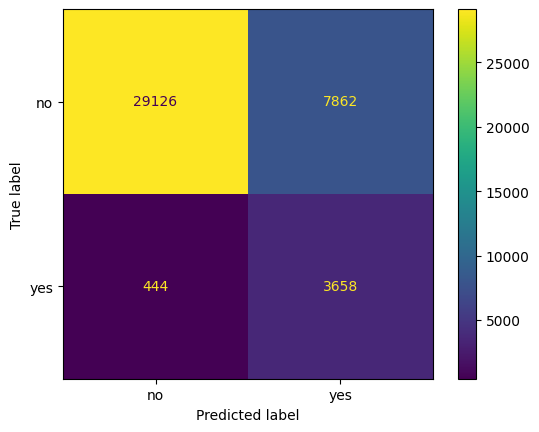


Medidas de validación Random Forest entrenado en un conjunto balanceado prediciendo sobre todo el conjunto de datos:
--------------------------------------------------
Accuracy = 0.7978583596982234
Precision = 0.31753472222222223
Recall = 0.8917601170160897
F1 score = 0.46831391627192415


In [97]:
#Se realizan las prediciones sobre todo el conjunto de datos
y_pred_rf = rf.predict(df_num_standard_data.values)

#Se calcula la matriz de confusión sobre los resultados del modelo y a partir de ello calculamos varias matricas
conf_mat_rf = confusion_matrix(df_num_original_classes.values, y_pred_rf)

accuracy_rf = (conf_mat_rf[0,0] + conf_mat_rf[1,1])/len(y_pred_rf)
precision_rf = (conf_mat_rf[1,1]) / (conf_mat_rf[1,1] + conf_mat_rf[0,1])
recall_rf = (conf_mat_rf[1,1]) / (conf_mat_rf[1,1] + conf_mat_rf[1,0])
f1_score_rf = (2*precision_rf*recall_rf)/(precision_rf+recall_rf)

#Imprimimos la matriz de confusion y los resultados de las medidas:
print("Matriz de confusión Random Forest entrenado en un conjunto balanceado prediciendo sobre todo el conjunto de datos:")
print("--------------------------------------------------")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_rf, display_labels=["no","yes"])
disp.plot()
plt.show()
print()

print("Medidas de validación Random Forest entrenado en un conjunto balanceado prediciendo sobre todo el conjunto de datos:")
print("--------------------------------------------------")
print(f"Accuracy = {accuracy_rf}")
print(f"Precision = {precision_rf}")
print(f"Recall = {recall_rf}")
print(f"F1 score = {f1_score_rf}")

No tiene un rendimiento tan bueno, al igual que KNearestNeighbors, se observa que ocurren muchos falsos positivos. Aunque es interesante ver que logra clasificar bastantes personas de la clase positiva y negativa correctamente. Pero puede ser que clasifique bien las muestras de la clase positiva porque las vio todas durante su entrenamiento.